# **Выявление побочных действий лекарств в микроблогах**

Выполнила Ирина Долгалева


## 1. Анализ и исследование данных

Установим то, по дефолту не установлено в колабе:

In [1]:
!pip install pyLDAvis
!pip install stanza

!pip install polyglot
!pip install pyicu
!pip install pycld2
!pip install morfessor

!polyglot download sentiment2.ru
!polyglot download sentiment2.en

[polyglot_data] Downloading package sentiment2.ru to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.ru is already up-to-date!
[polyglot_data] Downloading package sentiment2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.en is already up-to-date!


Заимпортируем все бибилиотеки для исследования данных:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import pyLDAvis.gensim
from collections import Counter
from tqdm import tqdm_notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk
from wordcloud import WordCloud, STOPWORDS
from polyglot.text import Text
import stanza

stanza.download('ru')  
stanza.download('en') 

import warnings 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
2020-05-29 09:47:17 INFO: Downloading default packages for language: ru (Russian)...
2020-05-29 09:47:19 INFO: File exists: /root/stanza_resources/ru/default.zip.
2020-05-29 09:47:26 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-05-29 09:47:26 INFO: Downloading default packages for language: en (English)...
2020-05-29 09:47:27 INFO: File exists: /root/stanza_resources/en/default.zip.
2020-05-29 09:47:32 INFO: Finished downloading models and saved to /root/stanza_resources.


Импорт данных:

In [0]:
df_ru_tr = pd.read_csv('df_ru_tr.csv', encoding='utf-8-sig')
df_ru_val = pd.read_csv('df_ru_val.csv', encoding='utf-8-sig')
df_ru_tr['language'] = 'Русский'
df_ru_val['language'] = 'Русский'

df_en_tr = pd.read_csv('df_en_tr.csv', encoding='utf-8-sig')
df_en_val = pd.read_csv('df_en_val.csv', encoding='utf-8-sig')
df_en_tr['language'] = 'Английский'
df_en_val['language'] = 'Английский'

In [0]:
df_tr = df_ru_tr.append(df_en_tr)
df_tr['sample_type'] = 'Тренировочная'

df_val = df_ru_val.append(df_en_val)
df_val['sample_type'] = 'Тестовая'

In [5]:
df_tr = df_tr[df_tr['tweet_pr'].isna() == False]
df_val = df_val[df_val['tweet_pr'].isna() == False]

df = df_tr.append(df_val)

X_train, X_test = df_tr[['tweet_pr']], df_val[['tweet_pr']]
y_train, y_test = df_tr['class'], df_val['class']

mask_ru = df['language'] == 'Русский'
mask_en = df['language'] == 'Английский'

df_tr.shape, df_val.shape

((26634, 8), (6656, 8))

Посчитаем базовые статистики по выборке:

In [6]:
df[df['language'] == 'Русский'].shape[0], df[df['language'] == 'Русский'].shape[0] / df.shape[0]

(7612, 0.22865725443076)

In [7]:
df[df['language'] == 'Английский'].shape[0], df[df['language'] == 'Английский'].shape[0] / df.shape[0]

(25678, 0.77134274556924)

In [8]:
df['class'][df['language'] == 'Русский'].mean(), df['class'][df['language'] == 'Английский'].mean(), df['class'].mean()

(0.08749343142406726, 0.09256951475971649, 0.0914088314809252)

Примеры текстов на разных языках:

In [9]:
print(df_ru_tr['class'].loc[1], '\n', df_ru_tr['tweet'].loc[1])

1 
 15) На прошлой зимней олимпиаде большинство лыжников приехало со справкой о том что у них якобы астма. Сделано это было для того, чтобы легально принимать сальбутамол (то же что и я принимаю в ингаляторах) который расширяет объём легких. По сути допинг для здорового человека.


In [10]:
print(df_en_tr['class'].loc[20543], '\n', df_en_tr['tweet'].loc[20543])

1 
 @twittalesskels 😂😂😂😂 i'm high off this tamiflu rn i'm telling you


## Исследование целевой переменной

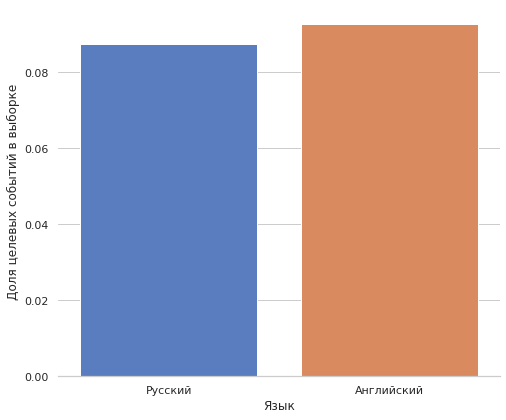

In [11]:
sns.set(style="whitegrid")

g = sns.catplot(x="language", y="class", order=['Русский','Английский'], data=df, aspect=1.2,
                height=6, kind="bar", palette="muted", ci=None)

g.despine(left=True)
g.set_axis_labels("Язык", "Доля целевых событий в выборке");

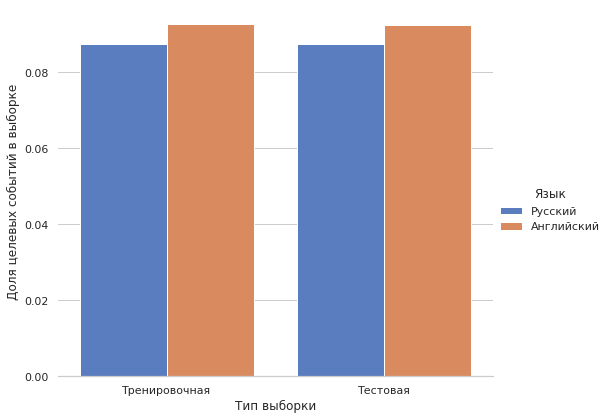

In [12]:
sns.set(style="whitegrid")

g = sns.catplot(x="sample_type", y="class", hue='language', hue_order=['Русский','Английский'], data=df, aspect=1.2,
                height=6, kind="bar", palette="muted", ci=None)

g.despine(left=True)
g.set_axis_labels("Тип выборки", "Доля целевых событий в выборке");
g._legend.set_title("Язык");

## Статистический анализ текстов


Длина текстов:

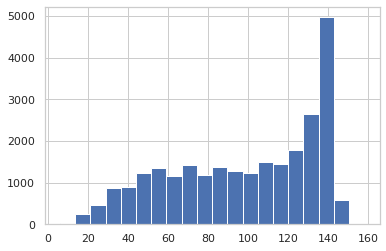

In [13]:
df['len'] = df['tweet'].apply(lambda x: len(x))
df['len_pr'] = df['tweet_pr'].apply(lambda x: len(x))

df['len'][df['language'] == 'Английский'].hist(bins=20);

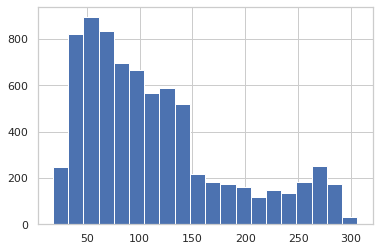

In [14]:
df['len'][(df['len'] < 310) & (df['language'] == 'Русский')].hist(bins=20);

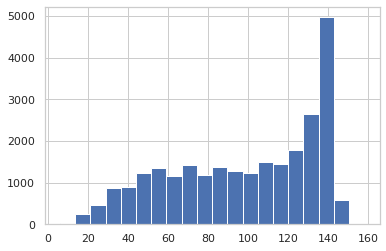

In [15]:
df['len'][(df['len'] < 310) & (df['language'] == 'Английский')].hist(bins=20);

Text(0, 0.5, 'Количество текстов')

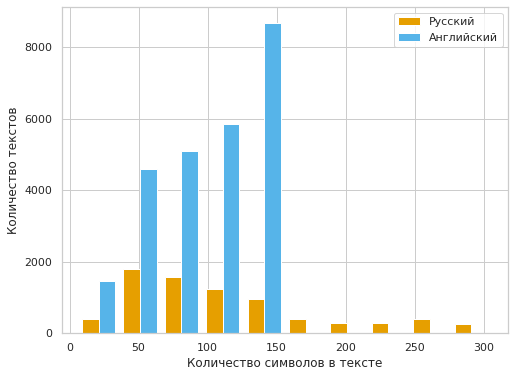

In [16]:
x1 = list(df[(df['language'] == 'Русский') & (df['len'] < 310)]['len'])
x2 = list(df[(df['language'] == 'Английский') & (df['len'] < 310)]['len'])

colors = ['#E69F00', '#56B4E9'] 
names = ['Русский', 'Английский']
         
plt.figure(figsize=(8,6))
plt.hist([x1, x2], bins = 10, color = colors, label=names)

plt.legend()
plt.xlabel('Количество символов в тексте')
plt.ylabel('Количество текстов')

In [17]:
df['len'][df['language'] == 'Английский'].mean(), df['len'][df['language'] == 'Английский'].std()

(98.07819923670068, 36.4521478526002)

In [18]:
df['len'][df['language'] == 'Русский'].mean(), df['len'][df['language'] == 'Русский'].std()

(114.34944823962165, 69.57077563119816)

In [19]:
df['len'].mean(), df['len'].std()

(101.79873835986783, 46.67147466835465)

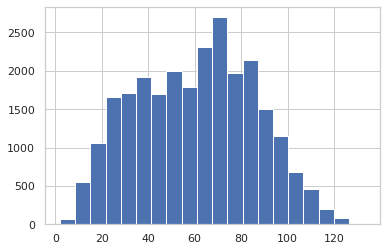

In [20]:
df['len_pr'][df['language'] == 'Английский'].hist(bins=20);

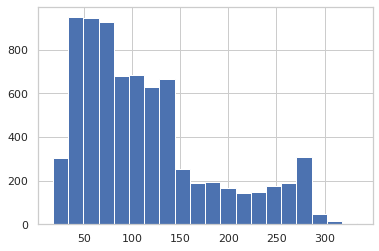

In [21]:
df['len'][df['language'] == 'Русский'].hist(bins=20);

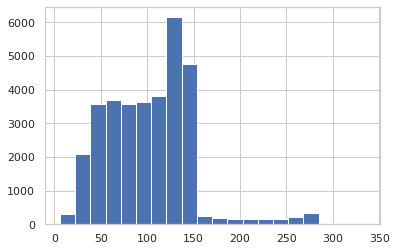

In [22]:
df['len'].hist(bins=20);

Количество слов:

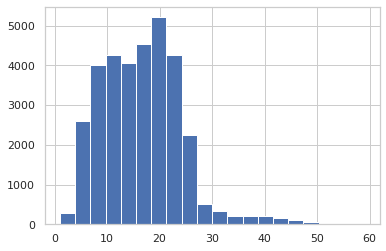

In [23]:
df['tweet'].str.split().map(lambda x: len(x)).hist(bins=20);

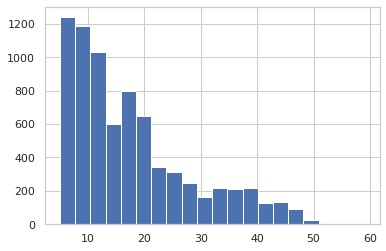

In [24]:
df['tweet'][df['language'] == 'Русский'].str.split().map(lambda x: len(x)).hist(bins=20);

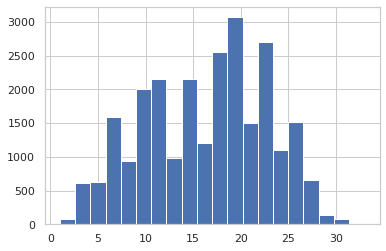

In [25]:
df['tweet'][df['language'] == 'Английский'].str.split().map(lambda x: len(x)).hist(bins=20);

Средняя длина слова:

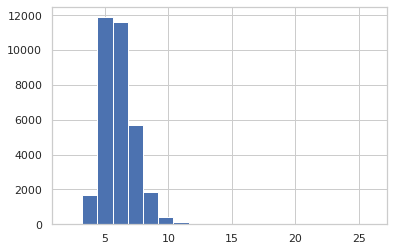

In [26]:
df['tweet_pr'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(bins=20);

In [27]:
df['tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).mean()

5.344658966949243

In [28]:
df['tweet'][df['language'] == 'Русский'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).mean()

5.663065542097355

In [29]:
df['tweet'][df['language'] == 'Английский'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).mean()

5.250270352180709

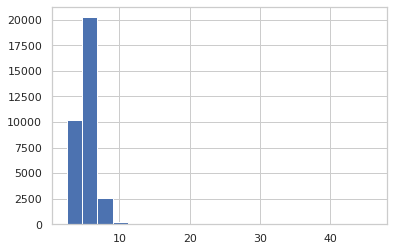

In [30]:
df['tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(bins=20);

Самые часто встречаемые слова:

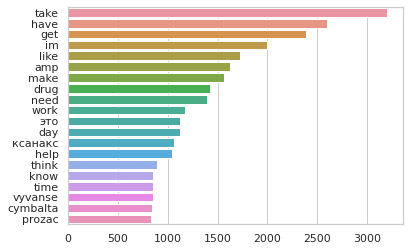

In [31]:
counter = Counter()
for index, row in df.iterrows():
    counter.update(row['tweet_pr'].split())

most = counter.most_common()

x, y= [], []
for word, count in most[:20]:
    x.append(word)
    y.append(count)
        
sns.barplot(x=y,y=x);

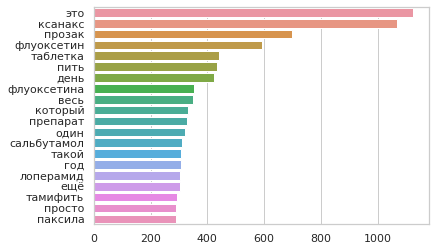

In [32]:
counter = Counter()
for index, row in df[mask_ru].iterrows():
    counter.update(row['tweet_pr'].split())

most = counter.most_common()

x, y= [], []
for word, count in most[:20]:
    x.append(word)
    y.append(count)
        
sns.barplot(x=y,y=x);

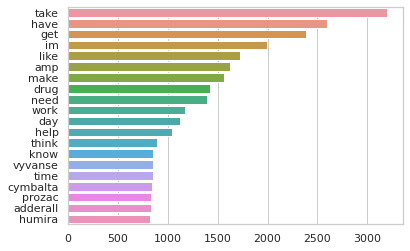

In [33]:
counter = Counter()
for index, row in df[mask_en].iterrows():
    counter.update(row['tweet_pr'].split())

most = counter.most_common()

x, y= [], []
for word, count in most[:20]:
    x.append(word)
    y.append(count)
        
sns.barplot(x=y,y=x);

## Анализ N-грамм

In [0]:
def get_top_ngram(corpus, k=None, n=None):
    vec = TfidfVectorizer(ngram_range=(k, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:15]

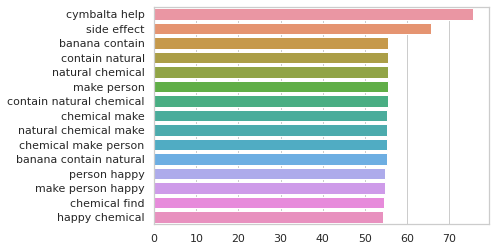

In [35]:
top_n_bigrams=get_top_ngram(df['tweet_pr'][mask_en], 2, 3)[:15]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x);

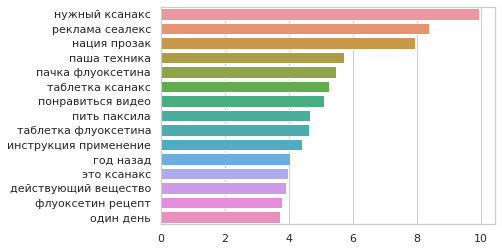

In [36]:
top_n_bigrams=get_top_ngram(df['tweet_pr'][mask_ru], 2, 4)[:15]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x);

## Тематический анализ текстов

In [0]:
def get_lda_objects(text):
    corpus = [x.split(' ') for x in text]    
    dic=gensim.corpora.Dictionary(corpus)
    
    print(dic)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dic,                                    
                                   passes = 5,
                                   workers = 2)
        
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    # bow_corpus = np.matrix(bow_corpus)
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [38]:
lda_model, bow_corpus, dic = get_lda_objects(df['tweet_pr'][mask_ru].values)

2020-05-29 09:47:54 WARNING: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


Dictionary(16068 unique tokens: ['время', 'дружок', 'ингалятор', 'настать', 'сальбутамол']...)


In [39]:
lda_model.show_topics()
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.018265 -0.079233       1        1  36.144070
1     -0.061148  0.055060       2        1  33.250572
2      0.079413  0.024172       3        1  30.605360, topic_info=         Term        Freq       Total Category  logprob  loglift
106   ксанакс  884.000000  884.000000  Default  30.0000  30.0000
110    прозак  576.000000  576.000000  Default  29.0000  29.0000
331  тамифить  249.000000  249.000000  Default  28.0000  28.0000
301   паксила  239.000000  239.000000  Default  27.0000  27.0000
402   сеалекс  151.000000  151.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
100     очень   56.289253  220.175323   Topic3  -6.0806  -0.1799
389      быть   53.350677  175.539963   Topic3  -6.1342  -0.0070
64   препарат   56.829197  274.768280   Topic3  -6.0710  -0.3919
43      такой   56.004433  258.947235   Topic3  -6.0857  -0.3472
80     просто   53.941216  245.034882   Topic3  -6.1232  -0.3295

[271 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
656       2  0.098208         tender
656       3  0.883876         tender
717       1  0.062622            ага
717       2  0.062622            ага
717       3  0.876707            ага
...     ...       ...            ...
24        3  0.233049            это
69        1  0.915546  эффективность
69        3  0.053856  эффективность
2167      2  0.125174            эээ
2167      3  0.876216            эээ

[454 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [40]:
lda_model, bow_corpus, dic = get_lda_objects(df['tweet_pr'][mask_en].values)

Dictionary(25396 unique tokens: ['cymbalta', 'depression', 'help', 'hurt', 'already']...)


In [41]:
lda_model.show_topics()
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.096125  0.105691       1        1  41.615166
0     -0.084535 -0.110311       2        1  30.148596
2      0.180660  0.004619       3        1  28.236235, topic_info=          Term         Freq        Total Category  logprob  loglift
34        have  2337.000000  2337.000000  Default  30.0000  30.0000
9         make  1374.000000  1374.000000  Default  29.0000  29.0000
0     cymbalta   713.000000   713.000000  Default  28.0000  28.0000
35          im  1808.000000  1808.000000  Default  27.0000  27.0000
100     effect   627.000000   627.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
151        get   253.629349  2190.187012   Topic3  -5.5799  -0.8913
68        take   232.490021  2867.151611   Topic3  -5.6669  -1.2477
8495    advair   166.480453   404.521667   Topic3  -6.0009   0.3767
302        say   165.957230   611.274231   Topic3  -6.0040  -0.0393
488      cause   159.632187   390.008392   Topic3  -6.0429   0.3713

[238 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
224       1  0.970806  abilify
224       2  0.027347  abilify
6235      1  0.979981  actonel
358       3  0.973250    acute
3904      3  0.982589      ada
...     ...       ...      ...
1265      2  0.011567  xarelto
1265      3  0.925390  xarelto
129       1  0.965003     yeah
129       2  0.030000     yeah
129       3  0.005000     yeah

[433 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

## Облако слов

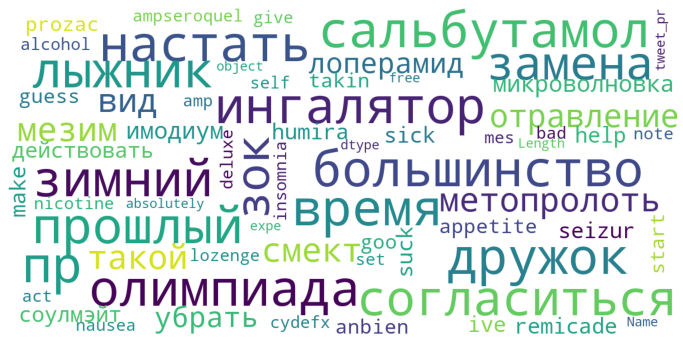

In [42]:
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['tweet_pr'])

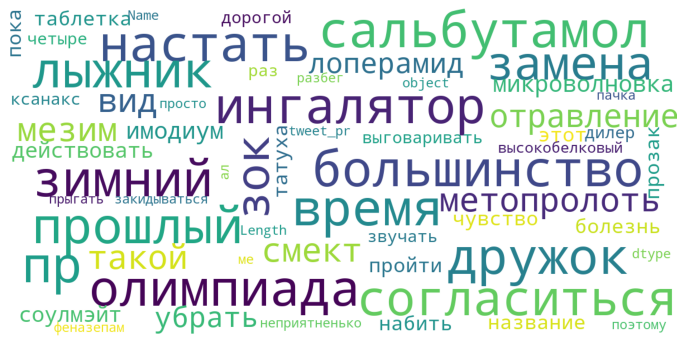

In [43]:
show_wordcloud(df['tweet_pr'][mask_ru])

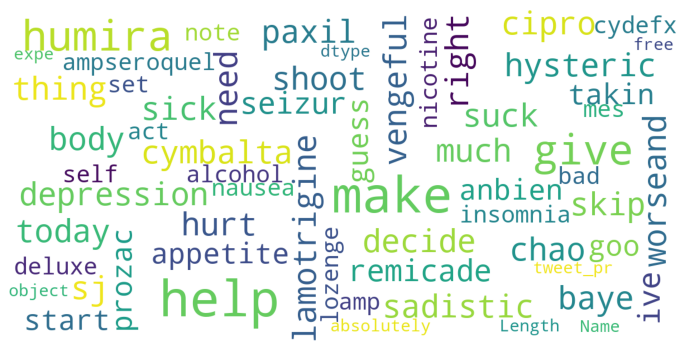

In [44]:
show_wordcloud(df['tweet_pr'][mask_en])

## Анализ тональности

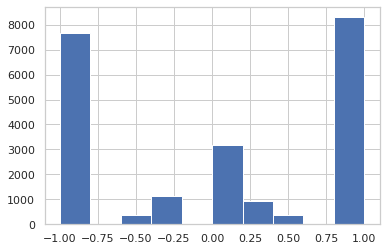

In [45]:
def polarity(text, lang):
    if lang == 'Русский': lang = 'ru'
    if lang == 'Английский': lang = 'en'
    try:
        text = Text(text)
        text.language = lang
        pol = text.polarity
    except:
        pol = -10
    return pol
    df.apply(lambda x: f(x.col_1, x.col_2), axis=1)

df['polarity_score']=df.apply(lambda x: polarity(x.tweet_pr, x.language), axis=1)
df['polarity_score'][df['polarity_score'] != -10].hist();

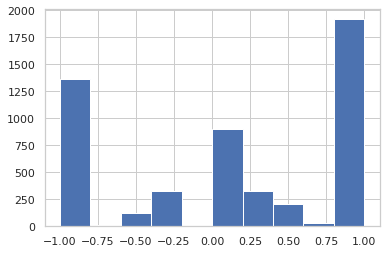

In [46]:
df['polarity_score'][(df['polarity_score'] != -10) & (mask_ru)].hist();

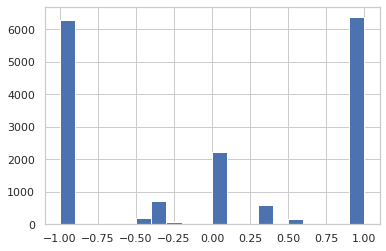

In [47]:
df['polarity_score'][(df['polarity_score'] != -10) & (mask_en)].hist(bins=20);

In [48]:
df_pol = df[df['polarity_score'] != -10]
df_pol.shape

(21969, 11)

In [49]:
df_pol[df_pol['language'] == 'Английский'].corr()

,Unnamed: 0,tweet_id,class,user_id,len,len_pr,polarity_score
Unnamed: 0,1.000000,0.878758,0.006067,0.203440,0.008557,0.032368,0.028127
tweet_id,0.878758,1.000000,-0.051364,0.228685,-0.008391,0.019096,0.030841
class,0.006067,-0.051364,1.000000,-0.037502,0.041328,0.011420,-0.122837
user_id,0.203440,0.228685,-0.037502,1.000000,0.007939,0.049996,0.007407
len,0.008557,-0.008391,0.041328,0.007939,1.000000,0.841234,0.026018
len_pr,0.032368,0.019096,0.011420,0.049996,0.841234,1.000000,-0.000704
polarity_score,0.028127,0.030841,-0.122837,0.007407,0.026018,-0.000704,1.000000


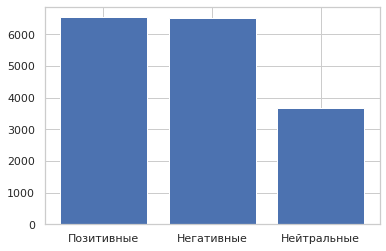

In [50]:
def sentiment(x):
    if x <= -0.5:
        return 'Негативные'
    elif x >= 0.5:
        return 'Позитивные'
    else:
        return 'Нейтральные'
    
df_pol['polarity'] = df_pol['polarity_score'].map(lambda x: sentiment(x))

df_sub_pol = df_pol[df_pol['language'] == 'Английский'] 
plt.bar(df_sub_pol.polarity.value_counts().index, df_sub_pol.polarity.value_counts());

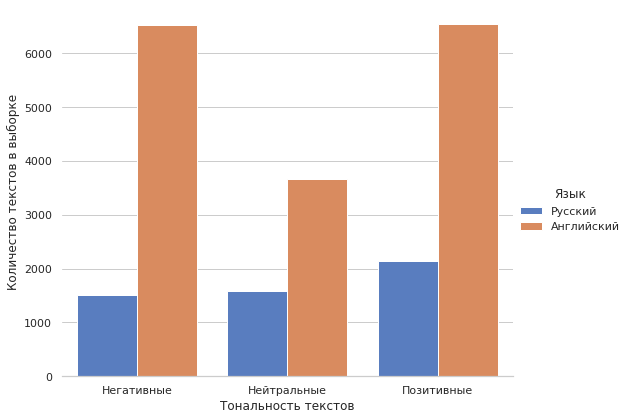

In [51]:
sns.set(style="whitegrid")

g = sns.catplot(x="polarity", kind="count", hue='language', hue_order=['Русский','Английский'], data=df_pol, aspect=1.2,
                height=6, palette="muted", ci=None)

g.despine(left=True)
g.set_axis_labels("Тональность текстов", "Количество текстов в выборке");
g._legend.set_title("Язык");

## Выделение именованных сущностей 

In [0]:
def plot_named_entity_barchart(text, lang):
    nlp = stanza.Pipeline(lang=lang, processors='tokenize,ner', verbose=False)
    
    def _get_ner(text):
        doc = nlp(text)
        joint = [(ent.text, ent.type) for sent in doc.sentences for ent in sent.ents]
        return joint

    def _get_ner_only(text):
        return [b for (a, b) in text]
        
    ent = text.apply(lambda x: _get_ner(x))
    print('Ready!')
    list_ners = ent.apply(lambda x: _get_ner_only(x))
    list_ners = [x for sub in list_ners for x in sub]
    counter = Counter(list_ners)
    count = counter.most_common()
    
    x, y = map(list,zip(*count))
    sns.barplot(x=y,y=x)

    return ent

Ready!


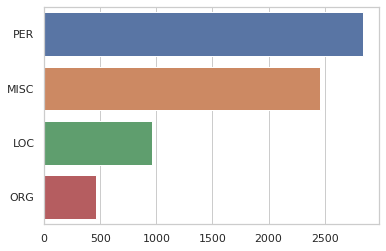

In [53]:
ent_ru = plot_named_entity_barchart(df['tweet'][mask_ru], 'ru')

Ready!


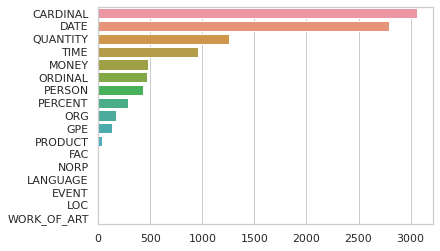

In [55]:
ent_en = plot_named_entity_barchart(df['tweet'][mask_en], 'en')

In [0]:
def plot_ent_values(all_ent, ent):
    def _ner(all_ent, ent):
        vals = [a for (a, b) in all_ent if b == ent]
        return vals

    gpe = all_ent.apply(lambda x: _ner(x, ent))
    gpe = [i for x in gpe for i in x]
    counter = Counter(gpe)

    x, y = map(list, zip(*counter.most_common(10)))
    ax = sns.barplot(y,x)
    ax.set(xlabel='Количество упоминаний в текстах', ylabel='Организации')
    plt.show();

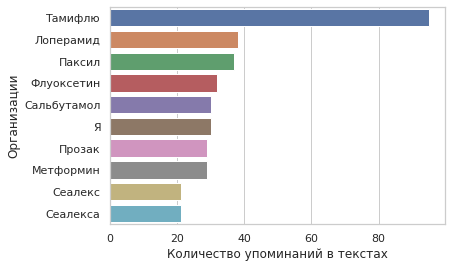

In [57]:
plot_ent_values(ent_ru, 'PER')

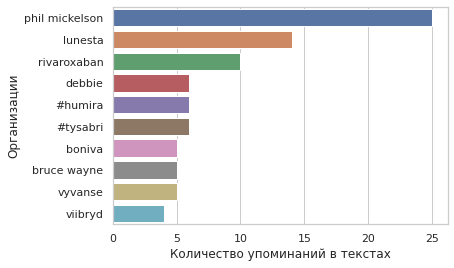

In [58]:
plot_ent_values(ent_en, 'PERSON')

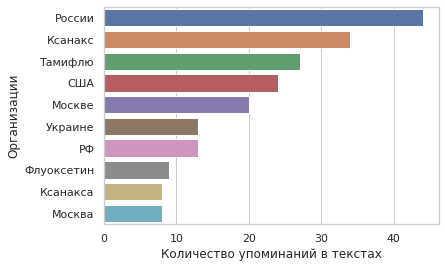

In [59]:
plot_ent_values(ent_ru, 'LOC')

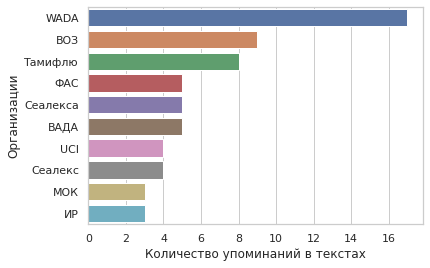

In [60]:
plot_ent_values(ent_ru, 'ORG')

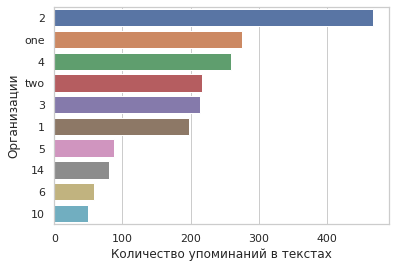

In [61]:
plot_ent_values(ent_en, 'CARDINAL')

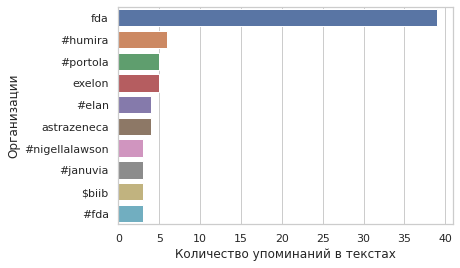

In [62]:
plot_ent_values(ent_en, 'ORG')

## Частотный анализ частей речи

In [0]:
def plot_parts_of_speach_barchart(text, lang):
    nlp = stanza.Pipeline(lang=lang, processors='tokenize,mwt,pos', verbose=False)
    
    def _get_pos(text):
        doc = nlp(text)
        joint = [(word.text, word.upos) for sent in doc.sentences for word in sent.words]
        return joint

    def _get_pos_only(text):
        return [b for (a, b) in text]
        
    ent = text.apply(lambda x: _get_pos(x))
    list_ners = ent.apply(lambda x: _get_pos_only(x))
    list_ners = [x for sub in list_ners for x in sub]
    counter = Counter(list_ners)
    count = counter.most_common(7)
    
    x, y = map(list,zip(*count))
    sns.barplot(x=y,y=x)

    return ent

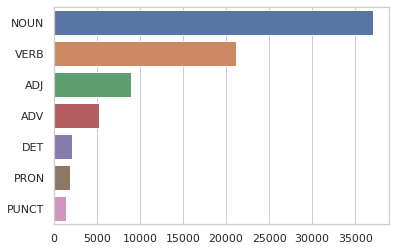

In [64]:
pos_ru = plot_parts_of_speach_barchart(df['tweet_pr'][mask_ru], lang='ru')

In [0]:
def plot_pos_values(all_pos, pos):
    def _pos(x, ent):
        vals = [a for (a, b) in x if b == pos]
        return vals

    gpe = all_pos.apply(lambda x: _pos(x, pos))
    gpe = [i for x in gpe for i in x]
    counter = Counter(gpe)

    x, y = map(list, zip(*counter.most_common(10)))
    sns.barplot(y,x);

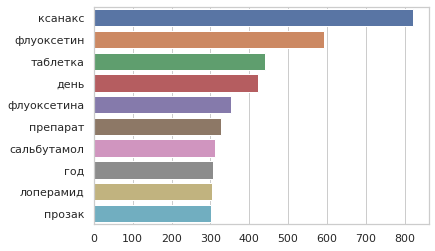

In [66]:
plot_pos_values(pos_ru, pos='NOUN')

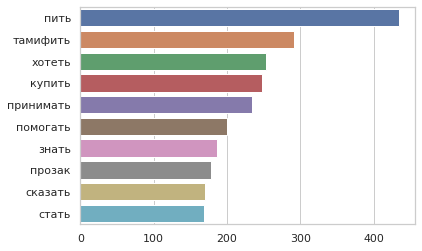

In [67]:
plot_pos_values(pos_ru, pos='VERB')

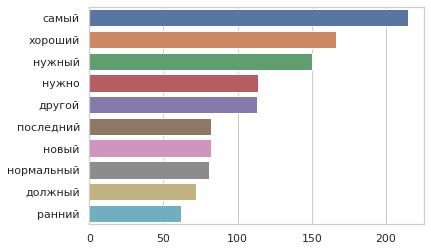

In [68]:
plot_pos_values(pos_ru, pos='ADJ')